# Hackathon

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [55]:
data = pd.read_excel('Hack_concentraducto_v01.xlsx', sheet_name='Data_Hackathon')
df1 = data.copy()
df1.head()

,tiempo,% Solido Bombeo concentrado_EB,Presión de Descarga_EB_1,Presión de Descarga_EB_2,Presion_Estación de Valvulas_EV1_1,Presion_Estación de Valvulas_EV1_2,Presión_SM-1,Presión_SM-2,Presión estación de valvulas 2_EV2_1,Presión estación de valvulas 2_EV2_2,Porcentaje de Solido Alimentación Espesador,Presión_EDT_1,Presión_EDT_2,Presión_EDT_3,Presión_SM-3,Presión_SM-4
0,2023-01-01 00:00:00,60.305771,-0.663051,1625.289917,3662.116943,3653.241699,16701.179688,3040.474121,3330.878174,3303.286377,59.756073,10653.394531,8614.203125,321.568634,2477.526611,1647.383789
1,2023-01-01 00:03:00,60.316761,-0.663393,1625.912354,3666.185059,3657.404053,16702.007812,3044.661621,3335.265137,3307.434814,59.675354,10658.351562,8619.733398,320.516357,2484.498535,1650.932861
2,2023-01-01 00:06:00,60.327747,-0.663736,1626.534790,3670.252930,3661.566406,16702.835938,3048.849121,3339.652100,3311.583252,59.709515,10658.579102,8621.905273,321.340149,2489.650879,1653.877686
3,2023-01-01 00:09:00,60.338734,-0.664078,1627.157349,3674.321045,3665.728760,16703.664062,3053.036621,3344.039062,3315.731689,59.712528,10663.964844,8622.951172,321.454895,2493.044678,1656.922974
4,2023-01-01 00:12:00,60.350990,-0.664420,1627.779785,3678.389160,3669.891357,16704.492188,3057.224121,3348.426025,3319.880127,59.747906,10667.239258,8625.802734,322.045898,2498.507568,1662.279785


In [56]:
df1.isnull().sum()

tiempo                                         0
% Solido  Bombeo concentrado_EB                0
Presión de Descarga_EB_1                       0
Presión de Descarga_EB_2                       0
Presion_Estación de Valvulas_EV1_1             0
Presion_Estación de Valvulas_EV1_2             0
Presión_SM-1                                   0
Presión_SM-2                                   0
Presión estación de valvulas 2_EV2_1           0
Presión estación de valvulas 2_EV2_2           0
Porcentaje de Solido Alimentación Espesador    0
Presión_EDT_1                                  0
Presión_EDT_2                                  0
Presión_EDT_3                                  0
Presión_SM-3                                   0
Presión_SM-4                                   0
dtype: int64

In [57]:
mean_concentrated = df1["% Solido  Bombeo concentrado_EB"].mean()
mean_concentrated

43.04818888272726

In [58]:
min_concentrated = df1["Presión de Descarga_EB_1"].min()
min_concentrated

-7.87132453918457

# Preprocesamiento
## Conversión de datos

In [59]:
df2 = data.copy()
conversion = 6.89476

df2['Presión de Descarga_EB_1'] = df2['Presión de Descarga_EB_1'].apply(lambda x: x * conversion)
df2['Presión de Descarga_EB_2'] = df2['Presión de Descarga_EB_2'].apply(lambda x: x * conversion)

In [60]:
from sklearn.preprocessing import StandardScaler

excluded_columns = ['tiempo']
normalize_columns = [col for col in df2.columns if col not in excluded_columns]

scaler = StandardScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df2[normalize_columns]), columns=normalize_columns)
df_normalized = pd.concat([df2[excluded_columns], df_normalized], axis=1)


In [61]:
df2.rename(columns=
           {'tiempo': 'T',
            '% Solido  Bombeo concentrado_EB': 'EB%', 
            'Presión de Descarga_EB_1': 'EB1',
            'Presión de Descarga_EB_2': 'EB2',
            'Presion_Estación de Valvulas_EV1_1': 'EV1_1',
            'Presión estación de valvulas 2_EV2_1': 'EV2_1',
            'Presion_Estación de Valvulas_EV1_2': 'EV1_2',
            'Presión estación de valvulas 2_EV2_2': 'EV2_2',
            'Presión_SM-1': 'SM1',
            'Presión_SM-2': 'SM2',
            'Presión_SM-3': 'SM3',
            'Presión_SM-4': 'SM4',
            'Porcentaje de Solido Alimentación Espesador': 'EDT%',
            'Presión_EDT_1': 'EDT1',
            'Presión_EDT_2': 'EDT2',
            'Presión_EDT_3': 'EDT3',
            }
           , inplace=True)

In [62]:
df_normalized.rename(columns=
           {'tiempo': 'T',
            '% Solido  Bombeo concentrado_EB': 'EB%', 
            'Presión de Descarga_EB_1': 'EB1',
            'Presión de Descarga_EB_2': 'EB2',
            'Presion_Estación de Valvulas_EV1_1': 'EV1_1',
            'Presión estación de valvulas 2_EV2_1': 'EV2_1',
            'Presion_Estación de Valvulas_EV1_2': 'EV1_2',
            'Presión estación de valvulas 2_EV2_2': 'EV2_2',
            'Presión_SM-1': 'SM1',
            'Presión_SM-2': 'SM2',
            'Presión_SM-3': 'SM3',
            'Presión_SM-4': 'SM4',
            'Porcentaje de Solido Alimentación Espesador': 'EDT%',
            'Presión_EDT_1': 'EDT1',
            'Presión_EDT_2': 'EDT2',
            'Presión_EDT_3': 'EDT3',
            }
           , inplace=True)

In [63]:
df_normalized = df2 ## TEMPORAL

# Visualización de datos

In [ ]:
pd.plotting.scatter_matrix(df2)

In [ ]:
pd.plotting.scatter_matrix(df_normalized)

In [ ]:
feats = df2.columns.difference(['T'])
for feat in df2.columns.difference(['T']):
 plt.plot(df2['T'], df2[feat])
plt.xlabel('T')
plt.show()

In [ ]:
for feat in feats:
 plt.plot(df_normalized['T'], df_normalized[feat])
plt.xlabel('T')
plt.show()

### Correlación entre SM2 y EV2
Analizando el conjunto de datos, se encontró que, en casos donde la presión de SM2 cambia entre dos tuplas de manera drástica, el cambio se propaga de manera instantánea a la presión de EV2. Esto se puede observar en el siguiente gráfico:

In [ ]:
plt.scatter(df_normalized['SM2'], df_normalized['EV1_1'], xlabel='SM2', ylabel='EV1_1')

In [ ]:
plt.scatter(df_normalized['SM4'], df_normalized['EV2_2'])

In [ ]:
plt.scatter(df_normalized['SM4'], df_normalized['EDT1'])

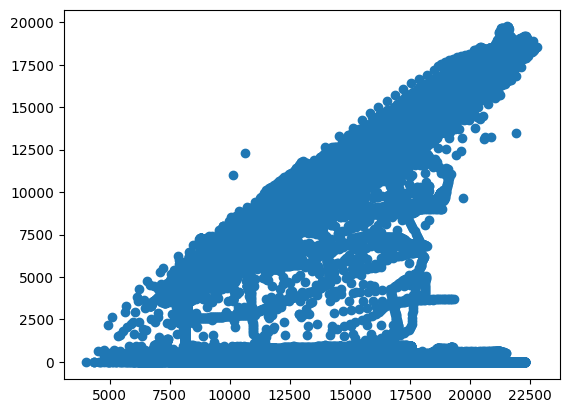

In [85]:
plt.scatter(df_normalized['SM1'], df_normalized['EB2'])


In [ ]:
plt.scatter(df_normalized['SM1'], df_normalized['SM2'])

In [ ]:
plt.scatter(df_normalized['SM3'], df_normalized['EV2_1'])

In [ ]:
plt.scatter(df_normalized['SM3'], df_normalized['EV1_2'])

# Modelo Lineal

In [64]:
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

## Predicción SM1

In [65]:
X_1 = df_normalized[df_normalized.columns.difference(['T', 'SM1'])]
y_1 = df_normalized['SM1']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=42, test_size=0.4)

### Regresión Linear

In [66]:
sm1 = LinearRegression()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7619118923106403, MAE = 1141.0736015973444


Observaciones:
Mayor puntuación, con un 30% de datos asignados para validación, con todos los datos de presión en [kPa]

### Regresión Lasso

In [67]:
sm1 = LassoCV(max_iter=5000)
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7437786713579749, MAE = 1195.3907803464697


En primer intento, se tuvo menor puntaje y problemas de convergencia.
Se aumenta número de iteraciones y se obtiene mayor demora, manteniendo puntaje.

### Elastic Net

In [68]:
sm1 = ElasticNetCV()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7206142734963006, MAE = 1250.5607053794197


### SGD

In [69]:
sm1 = SGDRegressor()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = -2.0113713927020896e+25, MAE = 1.1723133168805562e+16


### Random Forest

Observaciones:
Entrenamiento lento, fuera de plazo máximo. Descartado.

## Predicción SM2
Luego del análisis explorativo, se encontró una alta correlación entre las mediciones de SM2 y EV1, por lo cual se escogen sus sensores como únicas entradas del modelo.

In [71]:
X_2 = df_normalized[['EV1_1', 'EV1_2']] #['EV1_1'].array.reshape(-1, 1)# df_normalized[df_normalized.columns.difference(['T', 'SM2'])]
y_2 = df_normalized['SM2']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, random_state=42, test_size=0.4)

### Regresión Linear

In [72]:
sm2 = LinearRegression()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9951879786633565, MAE = 92.02318713802477


Observaciones:
Evaluando indivdualmente, al considerar solo la medición de entrada de EV1, se obtiene una puntuación de R2 = 0.9948631933284161, MAE = 0.061770157769054965; considerando entrada y salida de EV1, se obtiene R2 = 0.9951739335689458, MAE = 0.06143409021178661.

### Regresión Lasso

In [78]:
sm2 = LassoCV()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM1: R2 = 0.9951883007623118, MAE = 91.88570648924468


### Elastic Net

In [83]:
sm2 = ElasticNetCV()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9951855931811426, MAE = 92.00102721888317


### SGD

In [84]:
sm2 = SGDRegressor()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = -1.2492118185757524e+24, MAE = 1599150855826522.8


## Predicción SM3
Luego del análisis explorativo, se encontró una correlación entre las mediciones de SM3 y EV1, y entre SM3 y EB2.

In [73]:
X_3 = df_normalized[['EV1_2', 'EV2_1']]
y_3 = df_normalized['SM3']
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, random_state=42, test_size=0.4)

### Regresión Linear

In [74]:
sm3 = LinearRegression()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test) 
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.8643170593568688, MAE = 299.19840348020784


Observaciones:
Evaluando indivdualmente, al considerar solo la medición de salida de EV1, se obtiene una puntuación de R2 = 0.757428290149249, MAE = 0.36624686002811024; y considerando solo la medición de entrada de EV2, se obtiene R2 = 0.5894141038841055, MAE = 0.44782809908607935.
Considerando ambas mediciones, se obtiene R2 = 0.8643364789365919, MAE = 0.27408716724892734

### Regresión Lasso

In [86]:
sm3 = LassoCV()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.8643091746686353, MAE = 298.9819096823899


### Elastic Net

In [87]:
sm3 = ElasticNetCV()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.8643027666217925, MAE = 298.88125791282835


### SGD

In [92]:
sm3 = SGDRegressor()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = -1.3774620155837415e+24, MAE = 1215099017933186.0


## Predicción SM4
Luego del análisis explorativo, se encontró una correlación  entre las mediciones de SM4 y EV2, y entre SM4 y EDT1.

In [88]:
X_4 = df_normalized[['EV2_2', 'EDT1']] 
y_4 = df_normalized['SM4']
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, random_state=42, test_size=0.4)

### Regresión Linear

In [89]:
sm4 = LinearRegression()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.7570600063897843, MAE = 243.69239360067135


### Regresión Lasso

In [90]:
sm4 = LassoCV()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.757046281724932, MAE = 243.8043652933039


### Elastic Net

In [91]:
sm4 = ElasticNetCV()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.7570299148964366, MAE = 243.87522993680182


### SGD

In [93]:
sm4 = SGDRegressor()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = -1.3891238752329838e+24, MAE = 834388308547128.8
